<a href="https://colab.research.google.com/github/puzzlingConundrum/ResNet-CIFAR10/blob/main/Cifar10ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background
We will implement a ResNet from scratch and test it on the CIFAR-10 Dataset. The ResNet is a neural network architecture proposed as a solution to the learning degradation problem wherein adding more layers to a network increases the model's performance up to a certain point, but adding even more layers after that point result in significant performance degredation.

# The ResNet Solution
If we take a close look at the learning degradation problem, we see that it is a problem that theoretically should not exist: adding more layers to a network should never (theoretically) decrease the network's accuracy. For instance, let's consider a shallow network that models the mapping $N(x)$. Now add the layers $L_1, L_2, \dots, L_k$ to the network to obtain a deeper network. If the layers $L_1, L_2, \dots, L_k$ are set to the identity mapping, then the deeper network has exactly the same accuracy as the shallow network. So clearly, an optimal deep network must perform at least as well as the shallow network. But empirically this is the not the case. The solution proposed in the ResNet paper is based on the following hypothesis: **if the mapping we want the network to learn is $H(x)$, then the mapping $H(x)-x$ is actually easier to learn**. Now the new approach is to learn the mapping $F(x) = H(x)-x$ and then output the mapping $F(x)+x = H(x)$ as the output of the network. Empirically, this shows improved performance and is the key idea behind the ResNet.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

torch.manual_seed(0)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 256
train_split = 0.8

dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(dataset, batch_size = batch_size, shuffle=True, drop_last=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testset, validset = torch.utils.data.random_split(test_dataset, [int(train_split*len(test_dataset)), len(test_dataset) - int(train_split*len(test_dataset))])
validloader = DataLoader(validset, batch_size = batch_size, shuffle=True, drop_last=True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle=False, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


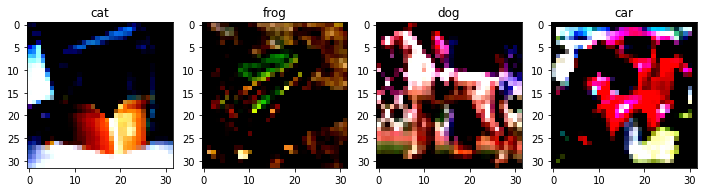

In [4]:
(sample, label) = next(iter(trainloader))

fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(1, 4, i+1)
    plt.imshow(sample[i].permute(1, 2, 0))
    plt.title(f"{classes[label[i]]}")

In [5]:
def calc_accuracy(pred, label):
    with torch.no_grad():
        _, pred2label = pred.max(dim=1)
        same = (pred2label == label).float()
        accuracy = same.sum().item() / same.numel()
    return accuracy

We start by implementing the basic building blocks of the ResNet: the ** ResidualBlock**. \\
The residual block consist of 2 convolutional layers and a shortcut connection. Going back to the proposed solution in the ResNet paper, the 2 convoutional layers learns the mapping $F(x) = H(x)-x$ and the shortcut connection simply adds the input to the output, giving us $F(x)+x = H(x)$. \\
 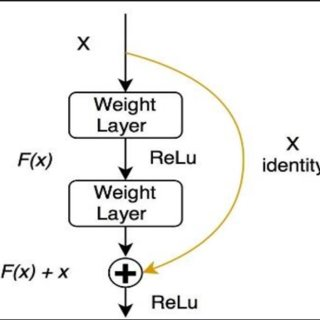 \\


---


In the case that the number of channels change between blocks, the shortcut connection consists of a convoutional layer to match the size of the channels.

---

The **ResidualChain** class simply consists of multiple **ResidualBlock** chained together into one unit.

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, upsample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.shortcut = nn.Identity()
        
        if (upsample):
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        stack = nn.Sequential(
            self.conv1,
            self.bn,
            self.relu,
            self.conv2,
            self.bn
        )
        return self.relu(stack(x) + self.shortcut(x))

class ResidualChain(nn.Module):
    def __init__(self, channels, num_blocks, stride=2, upsample=False):
        super(ResidualChain, self).__init__()
        layers = []
        out_channels = channels
        if (upsample):
            channels = out_channels // 2
        layers.append(ResidualBlock(channels, out_channels, stride, upsample))
        for n in range(num_blocks-1):
            layers.append(ResidualBlock(out_channels, out_channels))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return self.res(x)

Now we're ready to implement the **ResNet** class. Here, we simply take in a list of the number of blocks in each **ResidualChain** unit and combine them together. This class also takes in a list of the strides used in each ResidualChain. The input is processed by using an initial 2d convolution (parameters specified in the constructor) and then passed through the ResidualChains. Finally, we use average pooling and pass the output through a fully connected layer to obtain the predictions.

In [27]:
class ResNet(nn.Module):
    def __init__(self, in_channels, size, num_classes, conv1_size, pool, stride, layer_list, init_channels=64):
        super(ResNet, self).__init__()
        self.layers = []
        self.layer_list = layer_list
        self.prepool = nn.Sequential()
        if (pool):
            self.prepool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(init_channels)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=init_channels, kernel_size=conv1_size, stride=2, padding=1)
        self.channels = init_channels
        for idx, l in enumerate(layer_list):
            self.layers.append(ResidualChain(init_channels * (2**idx), l, stride[idx], idx > 0))
        self.resnet = nn.Sequential(*self.layers)
        w, h = size
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear((init_channels * (2**(len(layer_list)-1))), num_classes)
        

    def forward(self, x):
        x = self.relu(self.bn(self.conv1(x)))
        x = self.prepool(x)
        z = self.resnet(x)
        z = self.pool(z)
        z = z.view(-1, self.channels * (2**(len(self.layer_list)-1)))
        return self.fc(z)

In [37]:
device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"
model = ResNet(3, (32, 32), 10, conv1_size=3, pool=False, stride=[1,1,1,2], layer_list=[2,2,2,2]).to(device)
print(model)

NUM_EPOCHS = 30
learning_rate = 1e-1
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5)

ResNet(
  (prepool): Sequential()
  (relu): ReLU()
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet): Sequential(
    (0): ResidualChain(
      (res): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
          (shortcut): Identity()
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
          (shortcut): Identity(

In [38]:
for epoch in range(NUM_EPOCHS):
    training_loss = 0.0
    training_accuracy_list = []
    valid_loss = 0.0
    valid_accuracy_list = []

    for _, (batch, labels) in enumerate(trainloader):
        batch = batch.to(device).float()
        labels = labels.to(device)

        prediction = model(batch)
        loss = criterion(prediction, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        training_loss += loss.item() * batch.size(0)
        training_accuracy_list.append(calc_accuracy(prediction, labels))

    with torch.no_grad():
        for _, (batch, labels) in enumerate(validloader):
            batch = batch.cuda().float()
            labels = labels.to(device)

            prediction = model(batch)
            loss = criterion(prediction, labels)

            valid_loss += loss.item() * batch.size(0)
            valid_accuracy_list.append(calc_accuracy(prediction, labels))

    scheduler.step(valid_loss / len(validset))
    
    train_acc = sum(training_accuracy_list) / len(training_accuracy_list)
    valid_acc = sum(valid_accuracy_list) / len(valid_accuracy_list)
    print(f"epoch {epoch+1}/{NUM_EPOCHS} : training_loss = {training_loss/len(dataset):.4f}, training_acc = {train_acc}, valid_loss = {valid_loss/len(validset):.4f}, valid_acc = {valid_acc}")


epoch 1/30 : training_loss = 1.8507, training_acc = 0.31858974358974357, valid_loss = 1.3564, valid_acc = 0.4453125
epoch 2/30 : training_loss = 1.3618, training_acc = 0.4971554487179487, valid_loss = 1.1339, valid_acc = 0.54296875
epoch 3/30 : training_loss = 1.1179, training_acc = 0.5921474358974359, valid_loss = 0.9527, valid_acc = 0.6166294642857143
epoch 4/30 : training_loss = 0.9306, training_acc = 0.6671474358974359, valid_loss = 0.8313, valid_acc = 0.6852678571428571
epoch 5/30 : training_loss = 0.8171, training_acc = 0.7101963141025641, valid_loss = 0.7875, valid_acc = 0.6852678571428571
epoch 6/30 : training_loss = 0.7157, training_acc = 0.7493990384615384, valid_loss = 0.6382, valid_acc = 0.7533482142857143
epoch 7/30 : training_loss = 0.6307, training_acc = 0.7796274038461538, valid_loss = 0.6166, valid_acc = 0.7739955357142857
epoch 8/30 : training_loss = 0.5622, training_acc = 0.8047275641025641, valid_loss = 0.5410, valid_acc = 0.7829241071428571
epoch 9/30 : training_lo

In [39]:
test_acc_list = []

with torch.no_grad():
    for _, (batch, labels) in enumerate(testloader):
        batch = batch.cuda().float()
        labels =  labels.to(device)

        prediction = model(batch)
        loss = criterion(prediction, labels)

        test_acc_list.append(calc_accuracy(prediction, labels))
    test_acc = sum(test_acc_list) / len(test_acc_list)
    print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8884


In [49]:
torch.save(model.state_dict(), '/content/drive/My Drive/resnet18.pt')